In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner
import json
import argparse
import os
import sys

In [2]:
chain_folder = "all_chains/chains_earth_4_Jun23/"
burn_frac = 0.1

In [3]:
if os.path.isfile(f"{chain_folder}/chain_1.txt"):
    chain_file = f"{chain_folder}/chain_1.txt"
elif os.path.isfile(f"{chain_folder}/chain_1.0.txt"):
    chain_file = f"{chain_folder}/chain_1.0.txt"
else:
    print("Could not find any chain file in the chain folder! Exiting!")

In [4]:
param_names = np.genfromtxt(f"{chain_folder}/params.txt", dtype=str)
psrlist = np.genfromtxt(f"{chain_folder}/psrlist.txt", dtype=str)
chain = np.loadtxt(chain_file)
print(f"Chain shape = {chain.shape}")

Chain shape = (94100, 101)


In [5]:
burn = int(chain.shape[0] * burn_frac)

In [32]:
def log2linear_weight(value, pmin, pmax):
    mask = np.logical_and(value>=pmin, value<=pmax)
    uniform_prior = 1 / (pmax-pmin)
    linexp_prior = np.log(10) * 10**value / (10**pmax - 10**pmin)
    
    weight = mask * linexp_prior / uniform_prior
    weight /= sum(weight)

    return weight

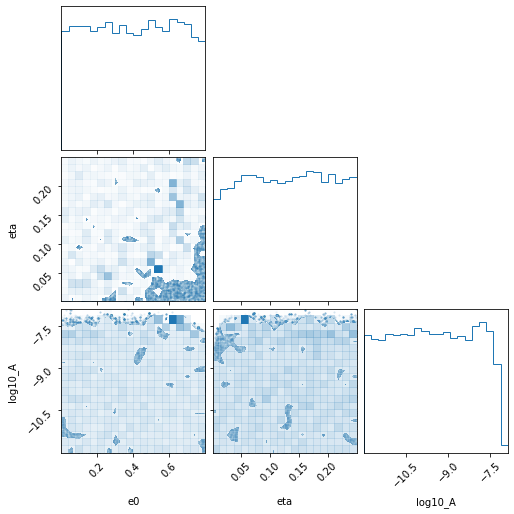

In [6]:
e_idx = np.where(param_names == "gwecc_e0")[0][0]
eta_idx = np.where(param_names == "gwecc_eta")[0][0]
A_idx = np.where(param_names == "gwecc_log10_A")[0][0]

corner.corner(chain[burn:, [e_idx, eta_idx, A_idx]], labels=["e0", "eta", "log10_A"],
                           color='C0', plot_contours=False, hist_kwargs={"density":True})
plt.show()

In [7]:
es = chain[burn:, e_idx]
etas = chain[burn:, eta_idx]
gwecc_log10_As = chain[burn:, A_idx]

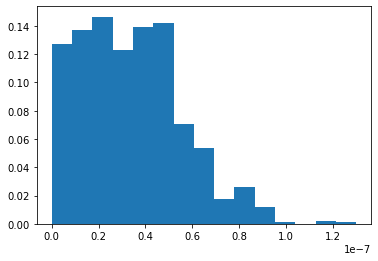

In [36]:
A_post_ws = log2linear_weight(gwecc_log10_As, -12, -6)

plt.hist(10**gwecc_log10_As, bins=15, weights=A_post_ws)
plt.show()

In [8]:
ep, etap, logAp, valid = np.genfromtxt("valid_param_space.txt").transpose()

ev = ep[valid==1]
etav = etap[valid==1]
logAv = logAp[valid==1]

In [9]:
print(len(ev), len(etav), len(logAv))

168492 168492 168492


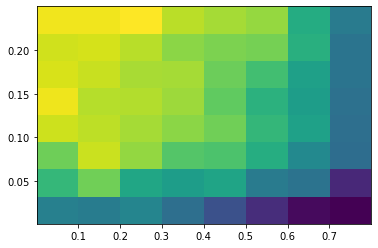

In [10]:
plt.hist2d(ev, etav, bins=8)
plt.show()

In [11]:
# Define the number of bins for the first two parameters
num_bins = 8

# Calculate the bin indices for the first two parameters
e_bins = np.linspace(0, 0.8, num_bins + 1)
eta_bins = np.linspace(0, 0.25, num_bins + 1)

print(e_bins, eta_bins)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8] [0.      0.03125 0.0625  0.09375 0.125   0.15625 0.1875  0.21875 0.25   ]


In [12]:
# Digitize the first two parameters to obtain the bin indices
e_bin_indices = np.digitize(es, e_bins)
eta_bin_indices = np.digitize(etas, eta_bins)

In [13]:
ev_bin_indices = np.digitize(ev, e_bins)
etav_bin_indices = np.digitize(etav, eta_bins)

print(ev_bin_indices[:20])

[7 3 2 2 7 4 6 3 8 4 6 6 4 7 3 8 4 5 5 7]


In [14]:
# Initialize an empty array to store the percentile values for each bin
percentiles = np.zeros((num_bins, num_bins))
valid_percentiles = np.zeros((num_bins, num_bins))

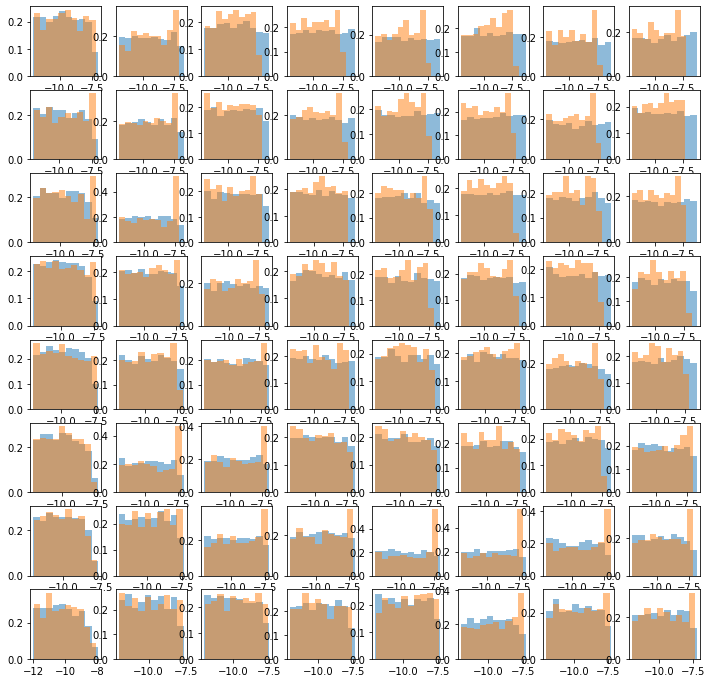

In [15]:
# Calculate the 95th percentile value for each bin
fig = plt.figure(figsize=(12, 12))
for i in range(num_bins):
    for j in range(num_bins):
        # Select the data points that fall within the current bin
        mask = (e_bin_indices == i + 1) & (eta_bin_indices == j + 1)
        # Calculate the 95th percentile of the third parameter for the current bin
        percentiles[i, j] = np.percentile(gwecc_log10_As[mask], 95)
        
        mask_valid = (ev_bin_indices == i + 1) & (etav_bin_indices == j + 1)
        valid_percentiles[i, j] = np.percentile(logAv[mask_valid], 95)
        
        plt.subplot(8, 8, 8*i+j+1)
        plt.hist(logAv[mask_valid], bins=10, alpha=0.5, density=True)
        plt.hist(gwecc_log10_As[mask], bins=10, alpha=0.5, density=True)
#         plt.title(f"e = {(e_bins[i] + e_bins[i+1])/2:.1f}, $\eta$ = {(eta_bins[j] + eta_bins[j+1])/2:.1f}")
plt.show()

In [16]:
print(percentiles, valid_percentiles)

[[-7.63853105 -7.35512692 -7.69953175 -7.7271333  -7.73637873 -7.64560327
  -7.58524545 -7.58330797]
 [-7.55089787 -7.35723191 -7.44994924 -7.65988441 -7.63932377 -7.65554843
  -7.69749361 -7.60750687]
 [-7.39250401 -7.20928348 -7.52925423 -7.10791273 -7.42948093 -7.60517463
  -7.62951836 -7.66674256]
 [-7.53879249 -7.40893673 -7.26510905 -7.46413657 -7.55405055 -7.48029087
  -7.62993274 -7.52156876]
 [-7.6871534  -7.58332656 -7.29205704 -7.47564805 -7.45644776 -7.24710937
  -7.58455978 -7.57690124]
 [-8.10525061 -7.26312563 -7.15734896 -7.40989169 -7.35729254 -7.46887086
  -7.67526762 -7.40030782]
 [-8.31239949 -7.63190669 -7.45689591 -7.34555507 -7.31566832 -7.31513905
  -7.23047834 -7.30852994]
 [-8.58094483 -7.91623075 -7.81520887 -7.74684899 -7.600989   -7.52395477
  -7.60631772 -7.7202034 ]] [[-7.58886988 -7.06185221 -6.88319787 -6.74953836 -6.68791044 -6.6409967
  -6.61021424 -6.52905633]
 [-7.56366393 -7.13929833 -6.93958076 -6.77350822 -6.70456972 -6.68571854
  -6.63699183 -6.

In [17]:
print(100*(percentiles - valid_percentiles)/valid_percentiles)

[[ 0.65439491  4.15294316 11.85980543 14.48387856 15.67706833 15.1273464
  14.75037228 16.14707526]
 [-0.16878137  3.05259105  7.35445706 13.08592476 13.9420438  14.50599353
  15.97865132 15.72557846]
 [-2.41525441 -0.0215796   7.9968373   3.40177479  9.14843753 13.40323196
  13.50796191 15.29907372]
 [-2.61256168  1.98692342  3.49505166  7.50099698 10.28020366  9.68403308
  12.5634637   9.96229163]
 [-2.07798728  2.93967021  2.06111492  6.18570026  6.54205315  4.5915275
   9.13767919 10.25495503]
 [ 1.33346331 -3.8604375  -2.17767112  2.99206688  3.36839037  5.0233039
   8.367074    3.86627421]
 [ 1.01137042 -1.82598079 -0.89751097 -1.02037017 -0.63125984 -0.77260637
  -1.95174959 -0.09299193]
 [ 0.96957957 -1.52861446 -0.69389076 -0.308727   -1.41279453 -2.36121884
  -0.80662675  0.89719384]]


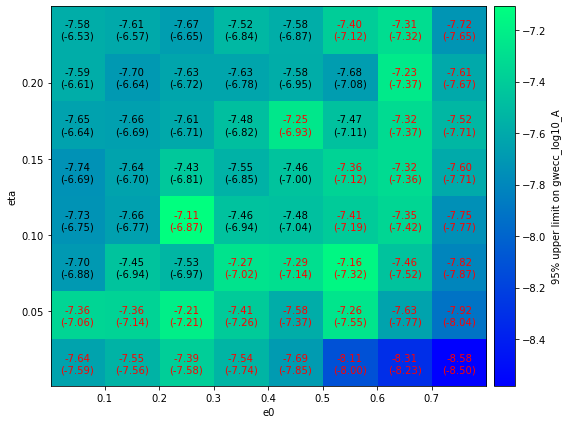

In [29]:
# Set the figure size and create the figure
fig = plt.figure(figsize=(8, 6))

# Create a colormap plot
ax = fig.add_subplot(111)
im = ax.imshow(percentiles.T, origin='lower', cmap='winter', aspect='auto', extent=[np.min(es), np.max(es), np.min(etas), np.max(etas)])
ax.set_xlabel('e0')
ax.set_ylabel('eta')
# ax.set_title('95% upper limit on gwecc_log10_A')

# Add text annotations to the colormap plot
for i in range(num_bins):
    for j in range(num_bins):
        value = percentiles[i, j]
        valid_value = valid_percentiles[i, j]
        if (value - valid_value)/valid_value > 0.05:
            ax.text((e_bins[i] + e_bins[i + 1]) / 2, (eta_bins[j] + eta_bins[j + 1]) / 2, 
                    f'{value:.2f}\n({valid_value:.2f})',
                    color='black', ha='center', va='center')
        else:
            ax.text((e_bins[i] + e_bins[i + 1]) / 2, (eta_bins[j] + eta_bins[j + 1]) / 2, 
                    f'{value:.2f}\n({valid_value:.2f})',
                    color='red', ha='center', va='center')


# Create the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('95% upper limit on gwecc_log10_A')

# Adjust subplot spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

# Save the figure with desired size and aspect ratio
# plt.savefig('colormap_plot.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [19]:
# # Create a colormap plot
# plt.figure(figsize=(8, 5))
# plt.imshow(percentiles.T, origin='lower', cmap='hot', aspect='auto', extent=[np.min(es), np.max(es), np.min(etas), np.max(etas)])
# plt.xlabel('First Parameter')
# plt.ylabel('Second Parameter')
# plt.title('95th Percentile of Third Parameter')
# plt.colorbar(label='Percentile')
# plt.show()